In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import uniform_filter1d
from scipy.io import loadmat
import re
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize lists for training and validation images
train_img_list = []
val_img_list = []
val_metadata = []

# Load and process training images
train_img_paths = list(Path("/kaggle/input/dataset/UCSDped2/Train").rglob("*.tif"))  # Get all .tif files recursively
for img_path in train_img_paths:
    img = cv.imread(str(img_path), cv.IMREAD_UNCHANGED)
    img = cv.resize(img, (235, 155))  # Resize image
    train_img_list.append(img)

train_images_np = np.array(train_img_list)  # Convert to numpy array

# Load and process validation images
val_dirs = [d for d in Path("/kaggle/input/dataset/UCSDped2/Test").iterdir() if d.is_dir() and not d.name.endswith("gt")]
for val_dir in val_dirs:
    val_img_files = list(val_dir.glob("*.tif"))  # Get all .tif files in the directory
    val_metadata.append((str(val_dir), len(val_img_files)))
    for img_path in val_img_files:
        img = cv.imread(str(img_path), cv.IMREAD_UNCHANGED)
        img = cv.resize(img, (235, 155))  # Resize image
        val_img_list.append(img)

val_images_np = np.array(val_img_list)  # Convert to numpy array


In [3]:
def create_edges(train_images):
    """
    Generate edge-detected images (e.g., using Canny edge detection).
    """
    train_edges = []
    for image in train_images:
        edges = cv.Canny(image, 100, 200)  # Canny edge detection
        train_edges.append(edges)
    return train_edges


def create_optical_flow(train_images):
    """
    Generate optical flow between consecutive frames using Farneback method.
    """
    train_motion = []
    prev_image = train_images[0]
    for i in range(1, len(train_images)):
        next_image = train_images[i]
        # Calculate optical flow using Farneback method
        flow = cv.calcOpticalFlowFarneback(prev_image, next_image, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        
        # Compute the magnitude of the flow at each pixel
        flow_magnitude = np.sqrt(flow[:,:,0]**2 + flow[:,:,1]**2)  # Euclidean distance
        train_motion.append(flow_magnitude)  # This will give you a single dimension per pixel
        
        prev_image = next_image
    
    return train_motion


def create_case_study(train_images, train_edges, train_motion):
    case_studies = {
        'FR': [],       # Only frames
        'FR+ED': [],    # Frames + Edge detection
        'FR+OF': [],    # Frames + Optical flow
        'FR+ED+OF': []  # Frames + Edge + Optical flow
    }
    
    # Ensure that train_images, train_edges, and train_motion are compatible in length
    # train_motion has one less frame, hence the assertion checks the lengths correctly
    assert len(train_images) == len(train_edges) == len(train_motion) + 1, "Mismatch in the number of frames and motion data"
    
    # Case 1: Only frames (FR)
    case_studies['FR'] = np.array(train_images)  # No modification needed for frames alone
    
    # Case 2: Frames + Edge detection (FR+ED)
    # Stack the frames and their corresponding edge-detected images along the last axis
    case_studies['FR+ED'] = np.array([
        np.stack([frame, edge], axis=-1) for frame, edge in zip(train_images, train_edges)
    ])
    
    # Case 3: Frames + Optical flow (FR+OF)
    # Stack the frames and their corresponding optical flow magnitudes along the last axis
    case_studies['FR+OF'] = np.array([
        np.stack([frame, flow], axis=-1) for frame, flow in zip(train_images[1:], train_motion)
    ])
    
    # Case 4: Frames + Edge + Optical flow (FR+ED+OF)
    # Stack the frames, edges, and optical flow components (flow x and y) along the last axis
    case_studies['FR+ED+OF'] = np.array([
        np.stack([frame, edge, flow], axis=-1) 
        for frame, edge, flow in zip(train_images[1:], train_edges[1:], train_motion)
    ])
    
    return case_studies

In [4]:
train_edges = create_edges(train_images_np)

# Create optical flow (using Farneback method)
train_motion = create_optical_flow(train_images_np)

# Generate the case studies
case_studies_train = create_case_study(train_images_np, train_edges, train_motion)

case_studies_train['FR']=np.expand_dims(case_studies_train['FR'], axis=-1)


In [5]:
val_edges=create_edges(val_images_np)

val_motion=create_optical_flow(val_images_np)

case_studies_val = create_case_study(val_images_np, val_edges, val_motion)

case_studies_val['FR']=np.expand_dims(case_studies_val['FR'], axis=-1)


In [7]:
val_metadata = sorted([(Path(path).name[-3:], count) for path, count in val_metadata if count != 0])

print(val_metadata)

# Read ground truth file
gt_file_path = Path("/kaggle/input/dataset/UCSDped2/Test/UCSDped2.m")  # Ensure it's a valid path
with gt_file_path.open('r') as file:
    lines = file.readlines()
gt=[]
for i in range(1,len(lines)):
    line=lines[i].split(" ")[-1]
    nrs = re.split(r'[ \[\]:]+', line)
    start, finish=int(nrs[1]),int(nrs[2])
    gt.append([0]*val_metadata[i-1][1])
    print(len([0]*val_metadata[i-1][1]))
    gt[i-1][start-1:finish]=[1] * (finish - start + 1)

print(val_metadata)

[('001', 180), ('002', 180), ('003', 150), ('004', 180), ('005', 150), ('006', 180), ('007', 180), ('008', 180), ('009', 120), ('010', 150), ('011', 180), ('012', 180)]
180
180
150
180
150
180
180
180
120
150
180
180
[('001', 180), ('002', 180), ('003', 150), ('004', 180), ('005', 150), ('006', 180), ('007', 180), ('008', 180), ('009', 120), ('010', 150), ('011', 180), ('012', 180)]


In [10]:
class CAE(nn.Module):
    def __init__(self, in_channels):
        super(CAE, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=1, stride=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=in_channels, kernel_size=15, stride=4)
        self._initialize_weights()

    def forward(self, x):
        # Encoder
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = torch.tanh(self.conv3(x))

        # Decoder
        x = torch.tanh(self.deconv1(x))
        x = self.upsample1(x)
        x = torch.tanh(self.deconv2(x))
        x = self.upsample2(x)
        x = torch.tanh(self.deconv3(x))
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                init.xavier_uniform_(module.weight)  # Xavier Uniform Initialization
                if module.bias is not None:
                    init.zeros_(module.bias)
                    

class CustomData(Dataset):
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_tensor = torch.tensor(self.images[idx], dtype=torch.float32)
        image_tensor = image_tensor / 255.0  # Scale to [0,1]
        image_tensor = 2 * image_tensor - 1  # Scale to [-1,1]
        return image_tensor, image_tensor



def compute_per_pixel_reconstruction_error(input_frame, reconstructed_frame):
    pixel_differences = input_frame - reconstructed_frame
    pixel_errors = np.sqrt(pixel_differences**2)
    return pixel_errors

def compute_frame_reconstruction_error(pixel_errors):
    return np.sum(pixel_errors)

def smooth_fre(fre_values, window_size):
    smooth = []
    for i in range(len(fre_values) - window_size):
        smooth.append(sum(fre_values[i:i+window_size]) / window_size)
    for i in range(len(fre_values) - window_size, len(fre_values)):
        smooth.append(sum(fre_values[i:]) / (len(fre_values) - i))
    return smooth

def compute_rre(smoothed_fre, min_val, max_val):
    smoothed_fre = np.array(smoothed_fre)
    return (smoothed_fre - min_val) / (max_val - min_val)

In [11]:
def train_case_study(case_study_name, train_data, val_data, in_channels, device):
    train_dataset = CustomData(train_data)
    val_dataset = CustomData(val_data)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=120, shuffle=False)

    model = CAE(in_channels=in_channels).to(device)
    optimizer = optim.Adagrad(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    best_val_metric = float('inf')
    best_model_path = f"best_model_{case_study_name}.pth"
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.permute(0, 3, 1, 2)  # Convert to (B, C, H, W)
            targets = targets.permute(0, 3, 1, 2)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        
        # Validation Phase
        model.eval()
        epoch_loss_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = inputs.permute(0, 3, 1, 2)
                targets = targets.permute(0, 3, 1, 2)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_loss_val += loss.item()
        
        avg_loss_val = epoch_loss_val / len(val_loader)
        print(f"{case_study_name} - Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Loss_val: {avg_loss_val:.4f}")
        
        if avg_loss_val < best_val_metric:
            best_val_metric = avg_loss_val
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved for {case_study_name} at epoch {epoch+1} with val_metric: {best_val_metric:.4f}")
    
    print(f"Training complete for {case_study_name}!")

In [35]:
import torch.optim as optim
import torch.nn.init as init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for case_name, train_data in case_studies_train.items():
    val_data = case_studies_val[case_name]
    in_channels = train_data.shape[-1]
    print(in_channels)
    train_case_study(case_name, train_data, val_data, in_channels, device)

3
FR+ED+OF - Epoch [1/100], Loss: 0.3087, Loss_val: 0.1997
Best model saved for FR+ED+OF at epoch 1 with val_metric: 0.1997
FR+ED+OF - Epoch [2/100], Loss: 0.1233, Loss_val: 0.0814
Best model saved for FR+ED+OF at epoch 2 with val_metric: 0.0814
FR+ED+OF - Epoch [3/100], Loss: 0.0629, Loss_val: 0.0747
Best model saved for FR+ED+OF at epoch 3 with val_metric: 0.0747
FR+ED+OF - Epoch [4/100], Loss: 0.0621, Loss_val: 0.0738
Best model saved for FR+ED+OF at epoch 4 with val_metric: 0.0738
FR+ED+OF - Epoch [5/100], Loss: 0.0600, Loss_val: 0.1141
FR+ED+OF - Epoch [6/100], Loss: 0.0696, Loss_val: 0.0739
FR+ED+OF - Epoch [7/100], Loss: 0.0593, Loss_val: 0.0729
Best model saved for FR+ED+OF at epoch 7 with val_metric: 0.0729
FR+ED+OF - Epoch [8/100], Loss: 0.0593, Loss_val: 0.0730
FR+ED+OF - Epoch [9/100], Loss: 0.0589, Loss_val: 0.0727
Best model saved for FR+ED+OF at epoch 9 with val_metric: 0.0727
FR+ED+OF - Epoch [10/100], Loss: 0.0587, Loss_val: 0.0742
FR+ED+OF - Epoch [11/100], Loss: 0.05

KeyboardInterrupt: 

In [13]:
import torch
import numpy as np
import torch.optim as optim
import torch.nn.init as init
from sklearn.metrics import roc_auc_score, roc_curve

# Define case study names
case_study_names = ["FR", "FR+ED", "FR+OF", "FR+ED+OF"]

# Initialize storage for evaluation results
results = {}

for case in case_study_names:
    print(f"\nEvaluating Case Study: {case}")

    # Load the corresponding model
 
    
    model_path = f"best_model_{case}.pth"
    if case == "FR":
        model = CAE(in_channels=1).to(device)
    elif case == "FR+ED":
        model = CAE(in_channels=2).to(device)
    elif case == "FR+OF":
        model = CAE(in_channels=2).to(device)
    elif case == "FR+ED+OF":
        model = CAE(in_channels=3).to(device)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Load validation data for the current case study
    val_data = case_studies_val[case]
    val_dataset = CustomData(val_data)
    val_loader = DataLoader(val_dataset, batch_size=120, shuffle=False)

    total_smooth_val = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.permute(0, 3, 1, 2)  # Shape: (batch, C, H, W), where C = channels
            outputs = model(inputs)

            # Convert tensors to numpy for error calculation
            inputs = inputs.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            

            # Compute pixel-wise reconstruction errors
            all_pixel_errors = [
                compute_per_pixel_reconstruction_error(inputs[i], outputs[i])
                for i in range(len(inputs))
            ]
            # Compute frame reconstruction errors
            fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]

            # Smooth the frame reconstruction errors
            smoothed_fre = smooth_fre(np.array(fre_values), window_size=5)
            total_smooth_val.extend(smoothed_fre)

    # Normalize using min and max values
    total_smooth_val = np.array(total_smooth_val)
    rre_values_val = compute_rre(total_smooth_val, min(total_smooth_val), max(total_smooth_val))
    print(len(rre_values_val))

    print(len(rre_values_val))
    flattened_gt = [nr for l in gt for nr in l]  # Flatten ground truth
    if len(flattened_gt)>len(rre_values_val):
        flattened_gt=flattened_gt[:len(flattened_gt)-1]
    auc = roc_auc_score(flattened_gt, rre_values_val)

    # Compute EER
    fpr, tpr, thresholds = roc_curve(flattened_gt, rre_values_val)
    fnr = 1 - tpr
    eer_threshold_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_threshold_index]
    eer_threshold = thresholds[eer_threshold_index]

    print(f"AUC: {auc:.4f}")
    print(f"EER: {eer:.4f} at Threshold: {eer_threshold:.4f}")

    # Store results for later comparison
    results[case] = {"AUC": auc, "EER": eer, "Threshold": eer_threshold}

# Print summary of results
print("\nFinal Evaluation Results:")
for case, metrics in results.items():
    print(f"{case}: AUC = {metrics['AUC']:.4f}, EER = {metrics['EER']:.4f} at Threshold {metrics['Threshold']:.4f}")



Evaluating Case Study: FR


<ipython-input-13-e459a6b4a75f>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


2010
2010
AUC: 0.5811
EER: 0.4751 at Threshold: 0.5503

Evaluating Case Study: FR+ED


<ipython-input-13-e459a6b4a75f>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


2010
2010
AUC: 0.6175
EER: 0.4171 at Threshold: 0.4603

Evaluating Case Study: FR+OF


<ipython-input-13-e459a6b4a75f>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


2009
2009
AUC: 0.6367
EER: 0.4282 at Threshold: 0.3549

Evaluating Case Study: FR+ED+OF


<ipython-input-13-e459a6b4a75f>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


2009
2009
AUC: 0.6419
EER: 0.4337 at Threshold: 0.3613

Final Evaluation Results:
FR: AUC = 0.5811, EER = 0.4751 at Threshold 0.5503
FR+ED: AUC = 0.6175, EER = 0.4171 at Threshold 0.4603
FR+OF: AUC = 0.6367, EER = 0.4282 at Threshold 0.3549
FR+ED+OF: AUC = 0.6419, EER = 0.4337 at Threshold 0.3613


<ipython-input-124-14a7176c6f9c>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


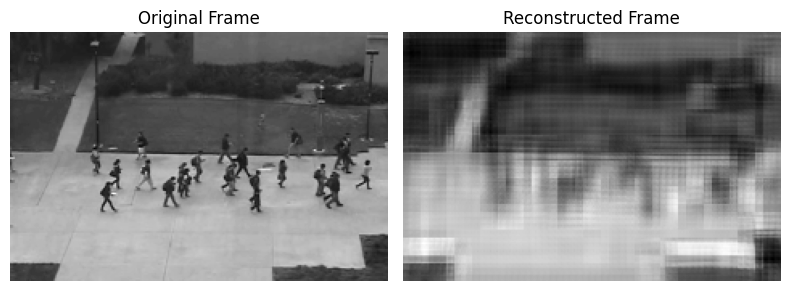

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import torch


case = 'FR'  # You are using a model based on the 'Frame' only

model = CAE(in_channels=1).to(device)  # Assuming CAE is your model class
model_path = f"best_model_{case}.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the image (assuming val_images is already loaded and image is selected)
image = val_images[5]  # Choose the 5th image for example
image = cv.resize(image, (235, 155))  # Resize to match the input shape

# Normalize the image and scale to [-1, 1]
image = image.astype(np.float32)  # Ensure the image is float for normalization
image = image / 255.0  # Scale to [0, 1]
image = 2 * image - 1  # Scale to [-1, 1]

# Convert the image to a tensor and add a batch dimension
image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add channel dimension (1) and batch dimension (1)

# Pass the image_tensor through the model
output = model(image_tensor.to(device))  # Get the reconstructed output from the model

# Normalize the images back to [0, 1] from [-1, 1] for better visualization
image_tensor = (image_tensor + 1) / 2.0
output = (output + 1) / 2.0

# Ensure the pixel values are in the range [0, 1]
image_tensor = np.clip(image_tensor.cpu().detach().numpy(), 0, 1)
output = np.clip(output.cpu().detach().numpy(), 0, 1)

# Plot the original image and the reconstructed image
plt.figure(figsize=(8, 4))

# Original Frame
plt.subplot(1, 2, 1)
plt.title("Original Frame")
plt.imshow(image_tensor.squeeze(), cmap='gray')  
plt.axis('off')

# Reconstructed Frame
plt.subplot(1, 2, 2)
plt.title("Reconstructed Frame")
plt.imshow(output.squeeze(), cmap='gray') 
plt.axis('off')

plt.tight_layout()
plt.show()
